In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Importing Dataset

In [42]:
dataset = pd.read_csv("UberDataset.csv")
dataset.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,01-02-2016 01:25,01-02-2016 01:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


Shape of the dataset

In [43]:
dataset.shape

(1156, 7)

In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non-null   object 
 3   START       1155 non-null   object 
 4   STOP        1155 non-null   object 
 5   MILES       1156 non-null   float64
 6   PURPOSE     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB


Data Preprocessing - As we understood that there are a lot of null values in PURPOSE column, so for that we will be filling the null values with a NOT keyword.


In [45]:
dataset['PURPOSE'].fillna("NOT", inplace=True)

/tmp/ipykernel_7903/3227455908.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['PURPOSE'].fillna("NOT", inplace=True)


Changing the START_DATE and END_DATE to the date_time format so that further it can be use to do analysis.

In [46]:
dataset['START_DATE'] = pd.to_datetime(dataset['START_DATE'], 
                                       errors='coerce')
dataset['END_DATE'] = pd.to_datetime(dataset['END_DATE'], 
                                     errors='coerce')

Splitting the START_DATE to date and time column and then converting the time into four different categories i.e. Morning, Afternoon, Evening, Night

In [47]:
from datetime import datetime

dataset['date'] = pd.DatetimeIndex(dataset['START_DATE']).date
dataset['time'] = pd.DatetimeIndex(dataset['START_DATE']).hour

#changing into categories of day and night
dataset['day-night'] = pd.cut(x=dataset['time'],
                              bins = [0,10,15,19,24],
                              labels = ['Morning','Afternoon','Evening','Night'])

Once we are done with creating new columns, we can now drop rows with null values.

In [48]:
dataset.dropna(inplace=True)

It is also important to drop the duplicates rows from the dataset. To do that, refer the code below

In [49]:
dataset.drop_duplicates(inplace=True)

Data Visualization
In this section, we will try to understand and compare all columns.

Let's start with checking the unique values in dataset of the columns with object datatype.

In [50]:
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)

unique_values = {}
for col in object_cols:
  unique_values[col] = dataset[col].unique().size
unique_values

{'CATEGORY': 2, 'START': 108, 'STOP': 112, 'PURPOSE': 7, 'date': 113}

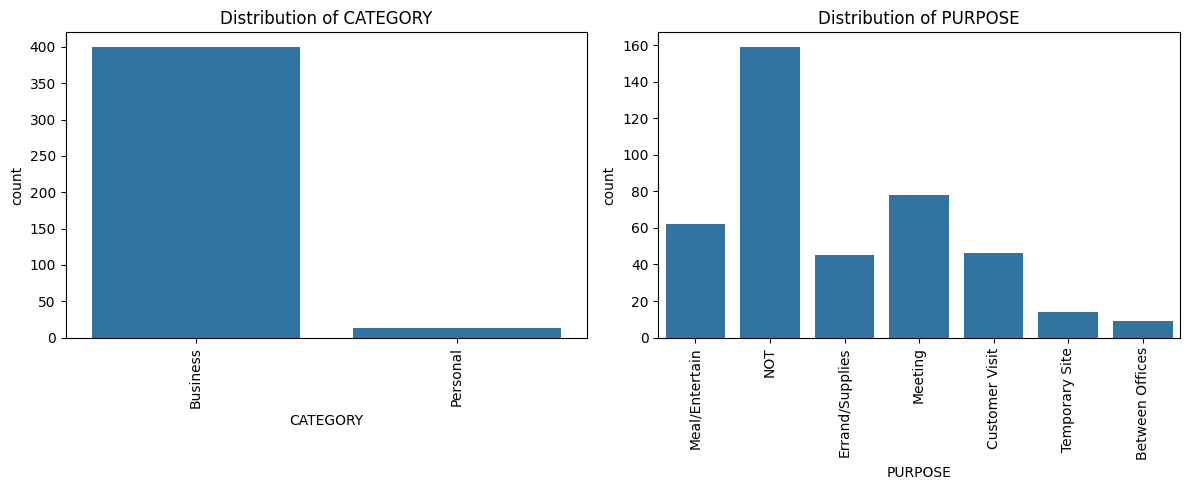

In [51]:
plt.figure(figsize=(12, 5))

# Plot 1: CATEGORY
plt.subplot(1, 2, 1)
sns.countplot(x='CATEGORY', data=dataset)
plt.title('Distribution of CATEGORY')
plt.xticks(rotation=90)

# Plot 2: PURPOSE
plt.subplot(1, 2, 2)
sns.countplot(x='PURPOSE', data=dataset)
plt.title('Distribution of PURPOSE')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


Let's do the same for time column, here we will be using the time column which we have extracted above.


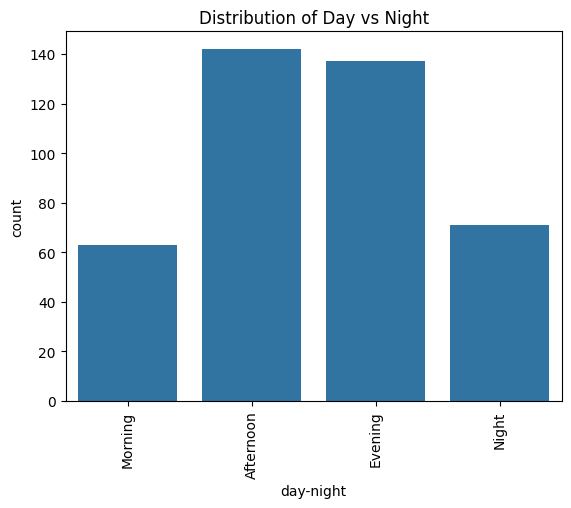

In [52]:
sns.countplot(x='day-night', data=dataset)
plt.xticks(rotation=90)
plt.title('Distribution of Day vs Night')
plt.show()


In [53]:
plt.figure(figsize=(15, 5))
sns.countplot(data=dataset, x='PURPOSE', hue='CATEGORY')
plt.xticks(rotation=90)
plt.show()

Insights from the above count-plots : 
Most of the rides are booked for business purpose.
Most of the people book cabs for Meetings and Meal / Entertain purpose.
Most of the cabs are booked in the time duration of 10am-5pm (Afternoon).

As we have seen that CATEGORY and PURPOSE columns are two very important columns. So now we will be using OneHotEncoder to categories them.

In [54]:
print(dataset.columns)


In [55]:
object_cols = ['Category', 'Purpose']


In [56]:
dataset.columns = dataset.columns.str.strip()


In [57]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Clean column names
dataset.columns = dataset.columns.str.strip()

# Define categorical columns
object_cols = ['CATEGORY', 'PURPOSE']

# Fill missing values (optional but recommended)
dataset['PURPOSE'] = dataset['PURPOSE'].fillna('NOT')

# Apply OneHotEncoding
OH_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
OH_cols = pd.DataFrame(OH_encoder.fit_transform(dataset[object_cols]))
OH_cols.index = dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out(object_cols)

# Drop original and concatenate
df_final = dataset.drop(object_cols, axis=1)
dataset = pd.concat([df_final, OH_cols], axis=1)


In [58]:
# Select only numerical columns for correlation calculation
numeric_dataset = dataset.select_dtypes(include=['number'])

sns.heatmap(numeric_dataset.corr(), 
            cmap='BrBG', 
            fmt='.2f', 
            linewidths=2, 
            annot=True)

# This code is modified by Susobhan Akhuli

Insights from the heatmap:
Business and Personal Category are highly negatively correlated, this have already proven earlier. So this plot, justifies the above conclusions.
There is not much correlation between the features.

Now, as we need to visualize the month data. This can we same as done before (for hours). 

In [59]:
dataset['MONTH'] = pd.DatetimeIndex(dataset['START_DATE']).month
month_label = {1.0: 'Jan', 2.0: 'Feb', 3.0: 'Mar', 4.0: 'April',
               5.0: 'May', 6.0: 'June', 7.0: 'July', 8.0: 'Aug',
               9.0: 'Sep', 10.0: 'Oct', 11.0: 'Nov', 12.0: 'Dec'}
dataset["MONTH"] = dataset.MONTH.map(month_label)

mon = dataset.MONTH.value_counts(sort=False)

# Month total rides count vs Month ride max count
df = pd.DataFrame({"MONTHS": mon.values,
                   "VALUE COUNT": dataset.groupby('MONTH',
                                                  sort=False)['MILES'].max()})

p = sns.lineplot(data=df)
p.set(xlabel="MONTHS", ylabel="VALUE COUNT")

Insights from the above plot : 
The counts are very irregular.
Still its very clear that the counts are very less during Nov, Dec, Jan, which justifies the fact that  time winters are there in Florida, US.

Visualization for days data.

In [60]:
dataset['DAY'] = dataset.START_DATE.dt.weekday
day_label = {
    0: 'Mon', 1: 'Tues', 2: 'Wed', 3: 'Thus', 4: 'Fri', 5: 'Sat', 6: 'Sun'
}
dataset['DAY'] = dataset['DAY'].map(day_label)

In [61]:
day_label = dataset.DAY.value_counts()
sns.barplot(x=day_label.index, y=day_label);
plt.xlabel('DAY')
plt.ylabel('COUNT')

Now, let's explore the MILES Column .

We can use boxplot to check the distribution of the column.

In [62]:
sns.boxplot(dataset['MILES'])

As the graph is not clearly understandable. Let's zoom in it for values lees than 100.


In [63]:
sns.boxplot(dataset[dataset['MILES']<100]['MILES'])

It's bit visible. But to get more clarity we can use distplot for values less than 40.

In [64]:
sns.distplot(dataset[dataset['MILES']<40]['MILES'])

Insights from the above plots :
- Most of the cabs booked for the distance of 4-5 miles.
- Majorly people chooses cabs for the distance of 0-20 miles.
- For distance more than 20 miles cab counts is nearly negligible.